In [ ]:
!pip install pandas tensorflow matplotlib scikit-learn opendatasets

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import opendatasets as od
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
KAGGLE_LINK = "https://www.kaggle.com/datasets/lillitarhea/the-office-script-lines"
DATASET_PATH = "./the-office-script-lines/The_Office_lines.csv"

In [ ]:
od.download(KAGGLE_LINK, force=False)

Skipping, found downloaded files in "./the-office-script-lines" (use force=True to force download)


In [ ]:
df = pd.read_csv(DATASET_PATH, nrows=10000)
df = df.drop(columns=["id", "season", "episode", "scene", "speaker", "deleted"])
df = df.dropna()

sentences = df["line_text"]
print(sentences[:10])

0    All right Jim. Your quarterlies look very good...
1           Oh, I told you. I couldn't close it. So...
2    So you've come to the master for guidance? Is ...
3           Actually, you called me in here, but yeah.
4      All right. Well, let me show you how it's done.
5    [on the phone] Yes, I'd like to speak to your ...
6    I've, uh, I've been at Dunder Mifflin for 12 y...
7                                  Well. I don't know.
8    If you think she's cute now, you should have s...
9                                                What?
Name: line_text, dtype: object


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
input_sequences = [tokenizer.encode(s, add_special_tokens=True) for s in sentences]
sequence_length = [len(tokenizer.encode(s, add_special_tokens=True)) for s in sentences]

In [ ]:
MAX_SEQ_LEN = 25

In [ ]:
x = [seq[:-1] for seq in input_sequences]
y = [seq[-1:] for seq in input_sequences]

# Padding Sequence
x = pad_sequences(x, maxlen=MAX_SEQ_LEN - 1, padding="post", truncating="post")
y = pad_sequences(x, maxlen=MAX_SEQ_LEN - 1, padding="post", truncating="post")

In [ ]:
# Train Test Split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  output = tf.matmul(attention_weights, value)
  return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads

    assert d_model % num_heads == 0

    self.depth = d_model // num_heads
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concatted_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(concatted_attention)
    return output, attention_weights

In [ ]:
def point_wise_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation="relu"),
      tf.keras.layers.Dense(d_model)
  ])

def positional_encoding(position, d_model):
  angle_rads = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
  angle_rads[:, 0::2] = np.sin(position * angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(position * angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, tf.float32)


In [ ]:
# Define Hyperparameters
NUM_HEADS = 8
D_MODEL = 128
DFF = 512
NUM_LAYERS = 2
INPUT_VOCAB_SIZE = len(tokenizer.vocab)
MAX_POS_ENC = MAX_SEQ_LEN
DROPOUT_RATE = 0.3
EPOCH = 10
BATCH_SIZE = 4

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(MAX_SEQ_LEN - 1, ), name="input")
x = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, D_MODEL)(inputs)
x += positional_encoding(MAX_POS_ENC, D_MODEL)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)

for _ in range(NUM_LAYERS):
  attn_output, _ = MultiHeadAttention(D_MODEL, NUM_HEADS)(x, x, x, mask=None)
  x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
  ffn_output = point_wise_forward_network(D_MODEL, DFF)(x)
  x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

outputs = tf.keras.layers.Dense(INPUT_VOCAB_SIZE, name="output", activation="softmax")(x)

transformers = tf.keras.Model(inputs=inputs, outputs=[outputs])
transformers.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(transformers.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 24, 128)        │      3,711,488 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 128)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24, 128)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 128),    │         66,048 │ dropout[0][0],         │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ dropout[0][0],         │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 128)        │              0 │ dropout[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 128)        │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 24, 128)        │        131,712 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 128)        │              0 │ layer_normalization[0… │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 128)        │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ [(None, None, 128),    │         66,048 │ layer_normalization_1… │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ layer_normalization_1… │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 24, 128)        │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 24, 128)        │            256 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 24, 128)        │        131,712 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)          

 Total params: 7,848,516 (29.94 MB)

 Trainable params: 7,848,516 (29.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = transformers.fit(
    x_train, np.expand_dims(y_train, -1),
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=(x_val, np.expand_dims(y_val, -1)),
)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 519s 250ms/step - accuracy: 0.4950 - loss: 3.6541 - val_accuracy: 0.5882 - val_loss: 2.3745
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 470s 234ms/step - accuracy: 0.6167 - loss: 2.0749 - val_accuracy: 0.6502 - val_loss: 1.9177
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 514s 240ms/step - accuracy: 0.6505 - loss: 1.7935 - val_accuracy: 0.6786 - val_loss: 1.7219
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 506s 242ms/step - accuracy: 0.6948 - loss: 1.5697 - val_accuracy: 0.7475 - val_loss: 1.4757
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 484s 233ms/step - accuracy: 0.7619 - loss: 1.2955 - val_accuracy: 0.8143 - val_loss: 1.1739
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 506s 235ms/step - accuracy: 0.8050 - loss: 1.0668 - val_accuracy: 0.8407 - val_loss: 1.0092
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 501s 234ms/step - accuracy: 0.8368 - loss: 0.8657 - val_accuracy: 0.8707 - val_loss: 0.8364
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 503s 234ms/step - ac

In [ ]:
loss, accuracy = transformers.evaluate(x_test, np.expand_dims(y_test, -1))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 828ms/step - accuracy: 0.9212 - loss: 0.6082
Test Loss: 0.5551831722259521
Test Accuracy: 0.9262083172798157


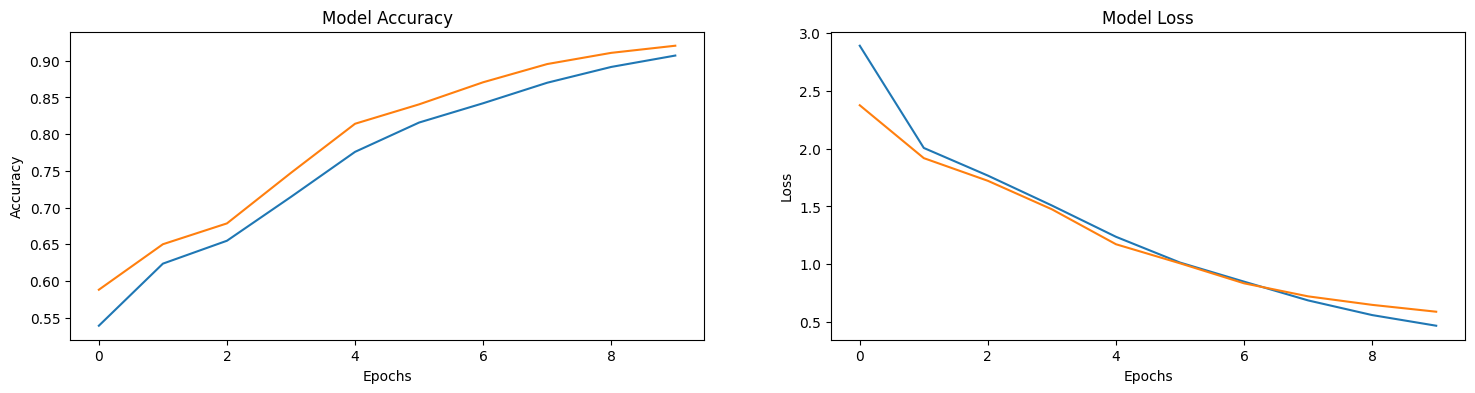

In [115]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [ ]:
def predict_next_token(model, tokenizer, text):
  encoded_input = tokenizer.encode(text, add_special_tokens=True)
  padded_input = pad_sequences([encoded_input], maxlen=MAX_SEQ_LEN - 1, padding="post", truncating="post")

  prediction = model.predict(padded_input)
  last_token_prediction = prediction[0, -1:]
  predicted_index = np.argmax(last_token_prediction)

  return tokenizer.decode(predicted_index)

# Actually, you called me in here, but yeah
sentence = "Actually, you called me in here, but "
predicted_token = predict_next_token(transformers, tokenizer, sentence)
print(f"Predicted Next Token: {predicted_token}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Next Token: [ P A D ]


In [ ]:
transformers.save("SSL.h5")